## Configurations for Colab

In [ ]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt install python-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install PyVirtualDisplay==3.0
    !pip install gymnasium==0.28.1
    from pyvirtualdisplay import Display
    
    # Start virtual display
    dis = Display(visible=0, size=(400, 400))
    dis.start()

# 07. N-Step Learning

[R. S. Sutton, "Learning to predict by the methods of temporal differences." Machine learning, 3(1):9–44, 1988.](http://incompleteideas.net/papers/sutton-88-with-erratum.pdf)

Q-learning accumulates a single reward and then uses the greedy action at the next step to bootstrap. Alternatively, forward-view multi-step targets can be used (Sutton 1988). We call it Truncated N-Step Return
from a given state $S_t$. It is defined as,

$$
R^{(n)}_t = \sum_{k=0}^{n-1} \gamma_t^{(k)} R_{t+k+1}.
$$

A multi-step variant of DQN is then defined by minimizing the alternative loss,

$$
(R^{(n)}_t + \gamma^{(n)}_t \max_{a'} q_{\theta}^{-}
(S_{t+n}, a')
- q_{\theta}(S_t, A_t))^2.
$$

Multi-step targets with suitably tuned $n$ often lead to faster learning (Sutton and Barto 1998).

In [1]:
import os
from collections import deque
from typing import Deque, Dict, List, Tuple
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output

## Replay buffer for N-step learning

There are a little bit changes in Replay buffer for N-step learning. First, we use `deque` to store the most recent n-step transitions.

```python
    self.n_step_buffer = deque(maxlen=n_step)
```

You can see it doesn't actually store a transition in the buffer, unless `n_step_buffer` is full.

```
    # in store method
    if len(self.n_step_buffer) < self.n_step:
        return ()
```

When the length of `n_step_buffer` becomes equal to N, it eventually stores the N-step transition, which is calculated by `_get_n_step_info` method.

(Please see *01.dqn.ipynb* for detailed description of the basic replay buffer.)

In [2]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(
        self, 
        obs_dim: int, 
        size: int, 
        batch_size: int = 32, 
        n_step: int = 3, 
        gamma: float = 0.99,
    ):
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0
        
        # for N-step Learning
        self.n_step_buffer = deque(maxlen=n_step)
        self.n_step = n_step
        self.gamma = gamma

    def store(
        self, 
        obs: np.ndarray, 
        act: np.ndarray, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool
    ) -> Tuple[np.ndarray, np.ndarray, float, np.ndarray, bool]:
        transition = (obs, act, rew, next_obs, done)
        self.n_step_buffer.append(transition)

        # single step transition is not ready
        if len(self.n_step_buffer) < self.n_step:
            return ()
        
        # make a n-step transition
        rew, next_obs, done = self._get_n_step_info(
            self.n_step_buffer, self.gamma
        )
        obs, act = self.n_step_buffer[0][:2]
        
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)
        
        return self.n_step_buffer[0]

    def sample_batch(self) -> Dict[str, np.ndarray]:
        indices = np.random.choice(
            self.size, size=self.batch_size, replace=False
        )

        return dict(
            obs=self.obs_buf[indices],
            next_obs=self.next_obs_buf[indices],
            acts=self.acts_buf[indices],
            rews=self.rews_buf[indices],
            done=self.done_buf[indices],
            # for N-step Learning
            indices=indices,
        )
    
    def sample_batch_from_idxs(
        self, indices: np.ndarray
    ) -> Dict[str, np.ndarray]:
        # for N-step Learning
        return dict(
            obs=self.obs_buf[indices],
            next_obs=self.next_obs_buf[indices],
            acts=self.acts_buf[indices],
            rews=self.rews_buf[indices],
            done=self.done_buf[indices],
        )
    
    def _get_n_step_info(
        self, n_step_buffer: Deque, gamma: float
    ) -> Tuple[np.int64, np.ndarray, bool]:
        """Return n step rew, next_obs, and done."""
        # info of the last transition
        rew, next_obs, done = n_step_buffer[-1][-3:]

        for transition in reversed(list(n_step_buffer)[:-1]):
            r, n_o, d = transition[-3:]

            rew = r + gamma * rew * (1 - d)
            next_obs, done = (n_o, d) if d else (next_obs, done)

        return rew, next_obs, done

    def __len__(self) -> int:
        return self.size

## Network

We are going to use a simple network architecture with three fully connected layers and two non-linearity functions (ReLU).

In [3]:
class Network(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        """Initialization."""
        super(Network, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_dim, 128), 
            nn.ReLU(),
            nn.Linear(128, 128), 
            nn.ReLU(), 
            nn.Linear(128, out_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        return self.layers(x)

## DQN Agent + N-step learning Agent

Here is a summary of DQNAgent class.

| Method           | Note                                                 |
| ---              | ---                                                  |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|compute_dqn_loss  | return dqn loss.                                     |
|update_model      | update the model by gradient descent.                |
|target_hard_update| hard update from the local model to the target model.|
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|plot              | plot the training progresses.                        |

We use two buffers: `memory` and `memory_n` for 1-step transitions and n-step transitions respectively. It guarantees that any paired 1-step and n-step transitions have the same indices (See `step` method for more details). Due to the reason, we can sample pairs of transitions from the two buffers once we have indices for samples.

```python
    def update_model(self) -> torch.Tensor:
        ...
        samples = self.memory.sample_batch()
        indices = samples["indices"]
        ...
        
        # N-step Learning loss
        if self.use_n_step:
            samples = self.memory_n.sample_batch_from_idxs(indices)
            ...
```

One thing to note that  we are gonna combine 1-step loss and n-step loss so as to control high-variance / high-bias trade-off.

(Search the comments with *N-step Leaning* to see any difference from DQN.)

In [4]:
class DQNAgent:
    """DQN Agent interacting with environment.
    
    Attribute:
        env (gym.Env): openAI Gym environment
        memory (ReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        epsilon (float): parameter for epsilon greedy policy
        epsilon_decay (float): step size to decrease epsilon
        max_epsilon (float): max value of epsilon
        min_epsilon (float): min value of epsilon
        target_update (int): period for target model's hard update
        gamma (float): discount factor
        dqn (Network): model to train and select actions
        dqn_target (Network): target model to update
        optimizer (torch.optim): optimizer for training dqn
        transition (list): transition information including 
                           state, action, reward, next_state, done
        use_n_step (bool): whether to use n_step memory
        n_step (int): step number to calculate n-step td error
        memory_n (ReplayBuffer): n-step replay buffer
    """

    def __init__(
        self, 
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        epsilon_decay: float,
        seed: int,
        max_epsilon: float = 1.0,
        min_epsilon: float = 0.1,
        gamma: float = 0.99,
        # N-step Learning
        n_step: int = 3,
    ):
        """Initialization.
        
        Args:
            env (gym.Env): openAI Gym environment
            memory_size (int): length of memory
            batch_size (int): batch size for sampling
            target_update (int): period for target model's hard update
            epsilon_decay (float): step size to decrease epsilon
            lr (float): learning rate
            max_epsilon (float): max value of epsilon
            min_epsilon (float): min value of epsilon
            gamma (float): discount factor
            n_step (int): step number to calculate n-step td error
        """
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        
        self.env = env
        self.batch_size = batch_size
        self.epsilon = max_epsilon
        self.epsilon_decay = epsilon_decay
        self.seed = seed
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.target_update = target_update
        self.gamma = gamma
        
        # memory for 1-step Learning
        self.memory = ReplayBuffer(
            obs_dim, memory_size, batch_size, n_step=1
        )
        
        # memory for N-step Learning
        self.use_n_step = True if n_step > 1 else False
        if self.use_n_step:
            self.n_step = n_step
            self.memory_n = ReplayBuffer(
                obs_dim, memory_size, batch_size, n_step=n_step, gamma=gamma
            )
        
        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)

        # networks: dqn, dqn_target
        self.dqn = Network(obs_dim, action_dim).to(self.device)
        self.dqn_target = Network(obs_dim, action_dim).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()
        
        # optimizer
        self.optimizer = optim.Adam(self.dqn.parameters())

        # transition to store in memory
        self.transition = list()
        
        # mode: train / test
        self.is_test = False

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # epsilon greedy policy
        if self.epsilon > np.random.random():
            selected_action = self.env.action_space.sample()
        else:
            selected_action = self.dqn(
                torch.FloatTensor(state).to(self.device)
            ).argmax()
            selected_action = selected_action.detach().cpu().numpy()
        
        if not self.is_test:
            self.transition = [state, selected_action]
        
        return selected_action

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated
        
        if not self.is_test:
            self.transition += [reward, next_state, done]
            
            # N-step transition
            if self.use_n_step:
                one_step_transition = self.memory_n.store(*self.transition)
            # 1-step transition
            else:
                one_step_transition = self.transition

            # add a single step transition
            # but it still stores an n-step transition!!!!
            if one_step_transition:
                self.memory.store(*one_step_transition)
    
        return next_state, reward, done

    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        samples = self.memory.sample_batch()
        indices = samples["indices"]
        loss = self._compute_dqn_loss(samples, self.gamma)
        
        # N-step Learning loss
        # we are gonna combine 1-step loss and n-step loss so as to
        # prevent high-variance.
        if self.use_n_step:
            samples = self.memory_n.sample_batch_from_idxs(indices)
            gamma = self.gamma ** self.n_step
            n_loss = self._compute_dqn_loss(samples, gamma)
            loss += n_loss

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()
        
    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False
        
        state, _ = self.env.reset(seed=self.seed)
        update_cnt = 0
        epsilons = []
        losses = []
        scores = []
        score = 0

        for frame_idx in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

            # if episode ends
            if done:
                state, _ = self.env.reset(seed=self.seed)
                scores.append(score)
                score = 0

            # if training is ready
            if len(self.memory) >= self.batch_size:
                loss = self.update_model()
                losses.append(loss)
                update_cnt += 1
                
                # linearly decrease epsilon
                self.epsilon = max(
                    self.min_epsilon, self.epsilon - (
                        self.max_epsilon - self.min_epsilon
                    ) * self.epsilon_decay
                )
                epsilons.append(self.epsilon)
                
                # if hard update is needed
                if update_cnt % self.target_update == 0:
                    self._target_hard_update()

            # plotting
            if frame_idx % plotting_interval == 0:
                self._plot(frame_idx, scores, losses, epsilons)
                
        self.env.close()
                
    def test(self, video_folder: str) -> None:
        """Test the agent."""
        self.is_test = True
        
        # for recording a video
        naive_env = self.env
        self.env = gym.wrappers.RecordVideo(self.env, video_folder=video_folder)
        
        state, _ = self.env.reset(seed=self.seed)
        done = False
        score = 0
        
        while not done:
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward
        
        print("score: ", score)
        self.env.close()
        
        # reset
        self.env = naive_env
        
    def _compute_dqn_loss(
        self, 
        samples: Dict[str, np.ndarray], 
        gamma: float
    ) -> torch.Tensor:
        """Return dqn loss."""
        device = self.device  # for shortening the following lines
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.LongTensor(samples["acts"].reshape(-1, 1)).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)

        # G_t   = r + gamma * v(s_{t+1})  if state != Terminal
        #       = r                       otherwise
        curr_q_value = self.dqn(state).gather(1, action)
        next_q_value = self.dqn_target(next_state).max(
            dim=1, keepdim=True
        )[0].detach()
        mask = 1 - done
        target = (reward + gamma * next_q_value * mask).to(self.device)

        # calculate dqn loss
        loss = F.smooth_l1_loss(curr_q_value, target)

        return loss

    def _target_hard_update(self):
        """Hard update: target <- local."""
        self.dqn_target.load_state_dict(self.dqn.state_dict())
                
    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float], 
        losses: List[float], 
        epsilons: List[float],
    ):
        """Plot the training progresses."""
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(131)
        plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
        plt.plot(scores)
        plt.subplot(132)
        plt.title('loss')
        plt.plot(losses)
        plt.subplot(133)
        plt.title('epsilons')
        plt.plot(epsilons)
        plt.show()

## Environment

You can see the [code](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/cartpole.py) and [configurations](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/cartpole.py#L91) of CartPole-v1 from Farama Gymnasium's repository.

In [7]:
import gym
from gym import spaces
import numpy as np

class CarRentalEnvironment(gym.Env):
    def __init__(self, max_cars=20, max_move=5, move_cost=2,
                 rent_reward=10, discount_factor=0.9, max_episode_steps=50):
        super(CarRentalEnvironment, self).__init__()

        self.max_cars = max_cars
        self.max_move = max_move
        self.move_cost = move_cost
        self.rent_reward = rent_reward
        self.discount_factor = discount_factor
        self.max_episode_steps = max_episode_steps  # Added maximum episode steps

        self.request_means = {
            1: [5, 3],  # Sunday
            2: [4, 3],  # Monday
            3: [3, 3],  # Tuesday
            4: [2, 1],  # Wednesday
            5: [1, 2],  # Thursday
            6: [4, 5],  # Friday
            7: [3, 5]   # Saturday
        }

        self.return_means = {
            1: [5, 4],  # Sunday
            2: [5, 3],  # Monday
            3: [4, 3],  # Tuesday
            4: [3, 3],  # Wednesday
            5: [2, 1],  # Thursday
            6: [1, 2],  # Friday
            7: [5, 4]   # Saturday
        }

        # Observation space: Number of cars at loc1, number of cars at loc2, and day of the week
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 1], dtype=np.int32),  # Minimum values for each component
            high=np.array([max_cars, max_cars, 7], dtype=np.int32),  # Maximum values for each component
            dtype=np.int32
        )

        # Action space: Number of cars to move between locations
        self.action_space = spaces.Discrete(2 * max_move + 1)

        self.state = (0, 0, 1)
        self.steps_taken = 0

    def step(self, action):
        assert self.action_space.contains(action), "Invalid action!"

        # Get request and return rates for the current day of the week
        request_mean = self.request_means[self.state[2]]
        return_mean = self.return_means[self.state[2]]

        # Simulate car rental requests and returns based on the means for the day of the week
        rental_requests = [np.random.poisson(request_mean[i]) for i in range(2)]
        rental_returns = [np.random.poisson(return_mean[i]) for i in range(2)]

        # Calculate reward for renting cars
        rent_reward = self.rent_reward * min(self.state[0], rental_requests[0])
        rent_reward += self.rent_reward * min(self.state[1], rental_requests[1])

        # Update the state based on rentals and returns
        cars_at_loc1 = self.state[0] - rental_requests[0]
        if cars_at_loc1 < 0:
            cars_at_loc1 = 0
        cars_at_loc1 += rental_returns[0]
        if cars_at_loc1 > self.max_cars:
            cars_at_loc1 = self.max_cars

        cars_at_loc2 = self.state[1] - rental_requests[1]
        if cars_at_loc2 < 0:
            cars_at_loc2 = 0
        cars_at_loc2 += rental_returns[1]
        if cars_at_loc2 > self.max_cars:
            cars_at_loc2 = self.max_cars
        
        
        #first convert action index to action value
        #we also have to handle negative rewards for cars moved
        real_action = action - 5

        if real_action >= 0 and real_action > cars_at_loc1:
            print('hi')

        if real_action >= 0 and real_action <= 5:
            cars_at_loc1 -= real_action
            if cars_at_loc1 < 0:
                real_action = real_action + cars_at_loc1
                cars_at_loc1 = 0
    
            cars_at_loc2 += real_action
            if cars_at_loc2 > self.max_cars:
                cars_at_loc2 = self.max_cars
        elif real_action >=-5 and real_action < 0:
            cars_at_loc2 -= abs(real_action)
            if cars_at_loc2 < 0:
                real_action = real_action + abs(cars_at_loc2)
                cars_at_loc2 = 0
    
            cars_at_loc1 += abs(real_action)
            if cars_at_loc1 > self.max_cars:
                cars_at_loc1 = self.max_cars
        

        # Calculate total reward as the sum of rent_reward and moving cost (if any)
        total_reward = rent_reward - abs(real_action) * self.move_cost
        if total_reward < 0:
            total_reward = 0

        next_day = self.state[2] % 7 + 1  # Cycle through days of the week

        self.state = (cars_at_loc1, cars_at_loc2, next_day)
        self.steps_taken += 1

        # Check if the episode is truncated
        if self.steps_taken >= self.max_episode_steps:
            return self.state, total_reward, True, True, {}
            self.steps_taken = 0

        return self.state, total_reward, False, False, {}

    def reset(self, seed):
        # Reset the environment to the initial state
        self.state = (0, 0, 1)
        self.steps_taken = 0

        # Return the state as a NumPy array and an empty dictionary
        return np.array(self.state, dtype=np.int32), {}


In [8]:
# environment
#env = gym.make("CartPole-v1", max_episode_steps=200, render_mode="rgb_array")
env = CarRentalEnvironment()

## Set random seed

In [9]:
seed = 777

def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

np.random.seed(seed)
seed_torch(seed)

## Initialize

In [10]:
# parameters
num_frames = 10000
memory_size = 2000
batch_size = 32
target_update = 100
epsilon_decay = 1 / 2000

# train
agent = DQNAgent(env, memory_size, batch_size, target_update, epsilon_decay, seed)

cuda


## Train

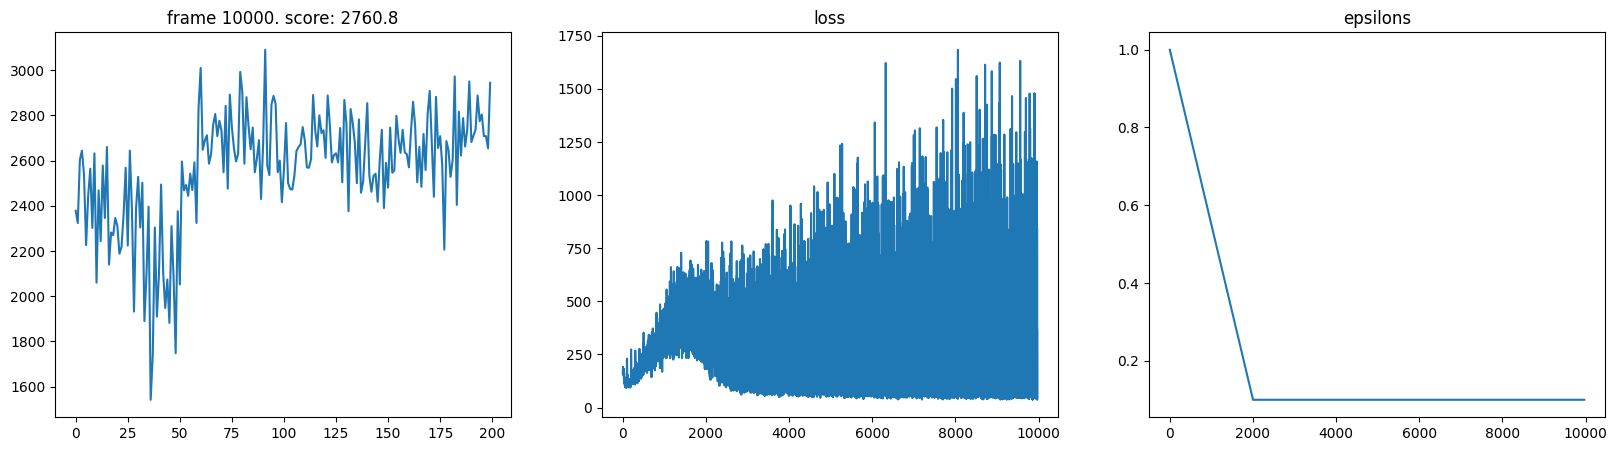

In [11]:
agent.train(num_frames)

## Test

Run the trained agent (1 episode).

In [10]:
video_folder="videos/n_step_learning"
agent.test(video_folder=video_folder)

Moviepy - Building video /Users/jinwoo.park/Repositories/rainbow-is-all-you-need/videos/n_step_learning/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/jinwoo.park/Repositories/rainbow-is-all-you-need/videos/n_step_learning/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/jinwoo.park/Repositories/rainbow-is-all-you-need/videos/n_step_learning/rl-video-episode-0.mp4
score:  200.0


## Render

In [11]:
import base64
import glob
import io
import os

from IPython.display import HTML, display


def ipython_show_video(path: str) -> None:
    """Show a video at `path` within IPython Notebook."""
    if not os.path.isfile(path):
        raise NameError("Cannot access: {}".format(path))

    video = io.open(path, "r+b").read()
    encoded = base64.b64encode(video)

    display(HTML(
        data="""
        <video width="320" height="240" alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
        </video>
        """.format(encoded.decode("ascii"))
    ))


def show_latest_video(video_folder: str) -> str:
    """Show the most recently recorded video from video folder."""
    list_of_files = glob.glob(os.path.join(video_folder, "*.mp4"))
    latest_file = max(list_of_files, key=os.path.getctime)
    ipython_show_video(latest_file)
    return latest_file


latest_file = show_latest_video(video_folder=video_folder)
print("Played:", latest_file)

Played: videos/n_step_learning/rl-video-episode-0.mp4
